# Debug and test flexOPT.jl

In [1]:
# Nobuaki Fuji @ipgp September 2025
using Pkg


cd(@__DIR__)
Pkg.activate("../..")
using BenchmarkTools
# below are the tools to debug the code
#using Revise # if we use Revise, myInclude will be Revise.myIncludet
using Profile, StatProfilerHTML


include("../src/batchRevise.jl") # Revise.jl will be automatically activated. If you do not want Revise then put using_revise = false
#using_revise=false

myInclude("../src/imageReader.jl") # read 2D images for models

myInclude("../src/OPTwrappers.jl") 


  Activating project at `~/Documents/Github/flexibleDSM`
┌ Info: Including with Revise: ../src/imageReader.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25
┌ Info: Including with Revise: ../src/batchImages.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25
┌ Info: Including with Revise: ../src/batchUseful.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25
┌ Info: Including with Revise: ../src/OPTwrappers.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25
┌ Info: Including with Revise: ../src/batchNewSymbolics.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25
┌ Info: Including with Revise: ../src/OPTnewEngines.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25
┌ Info: Including with Revise: ../src/batchNewSymbolics.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibl

In [2]:
in_vscode  = get(ENV, "VSCODE_PID", nothing) !== nothing

true

In [3]:
iExperiment = 1

# 'iExperiment' can be fixed to be 1 if the user does not need to perform benchmark tests
# (which should be the case for the most of the time when the software gets stabilised)

1

In [4]:
famousEquationType="2DacousticTime"
exprs,fields,vars,extexprs,extfields,extvars,coordinates,∂,∂²=famousEquations(famousEquationType)

(Differential(t)(Differential(t)(u(x, y, t))) - (Differential(x)(Differential(x)(u(x, y, t))) + Differential(y)(Differential(y)(u(x, y, t))))*(v(x, y)^2), u(x, y, t), v(x, y), f(x, y, t), f(x, y, t), 1, (x, y, t), Any[Differential(x), Differential(y), Differential(t)], Any[Differential(x) ∘ Differential(x), Differential(y) ∘ Differential(y), Differential(t) ∘ Differential(t)])

In [5]:
modelName="marmousi"

modelDefinitionMethod="2DimageFile" # ToyModel or 2DimageFile (or 1DsphericalPlanet)
model =nothing


if modelDefinitionMethod !== nothing
        
    #region Model input - option i) Model domain definition

    if modelDefinitionMethod === "ToyModel"
        DomainWindow=(DomainWindowT=1.0,DomainWindowX=1.0,DomainWindowY=1.0,DomainWindowZ=1.0)
        ModelSizeTXYZ=(ModelSizeT=101,ModelSizeX=101,ModelSizeY=101,ModelSizeZ=0)
    end

    #endregion

    #region Model input - option ii) Read a file (2D or 3D) and define Δs

    if modelDefinitionMethod === "2DimageFile"

        #imagefile="../data/model/random/colourful.jpg"
        #imagefile="../data/model/artemis/IMG_6098.jpeg"
        #imagefile="../data/model/random/tmp.png"
        imagefile = "../data/model/random/marmousi.png"
        colormap = "jet" #colormap can be RGB vector or predefined colormap

        #model=read2DimageModel(imagefile,colormap;Nwidth=10,Nheight=10,showRecoveredImage=false)
        model=read2DimageModel(imagefile,colormap;showRecoveredImage=false)
    end
    #endregion

    #region Model input - option iii) Read a file (1D spherical planet models)

    if modelDefinitionMethod ==="1DsphericalPlanet"
        # use some programmes that are developed during Xmas 2023
        # inputModels.jl
    end

#endregion
end

In [29]:
@show Nz,Nx=size(model)
Δz,Δx=(1.0,1,0)

(Nz, Nx) = size(model) = (676, 802)


(1.0, 1, 0)

In [22]:
using CairoMakie
CairoMakie.activate!()

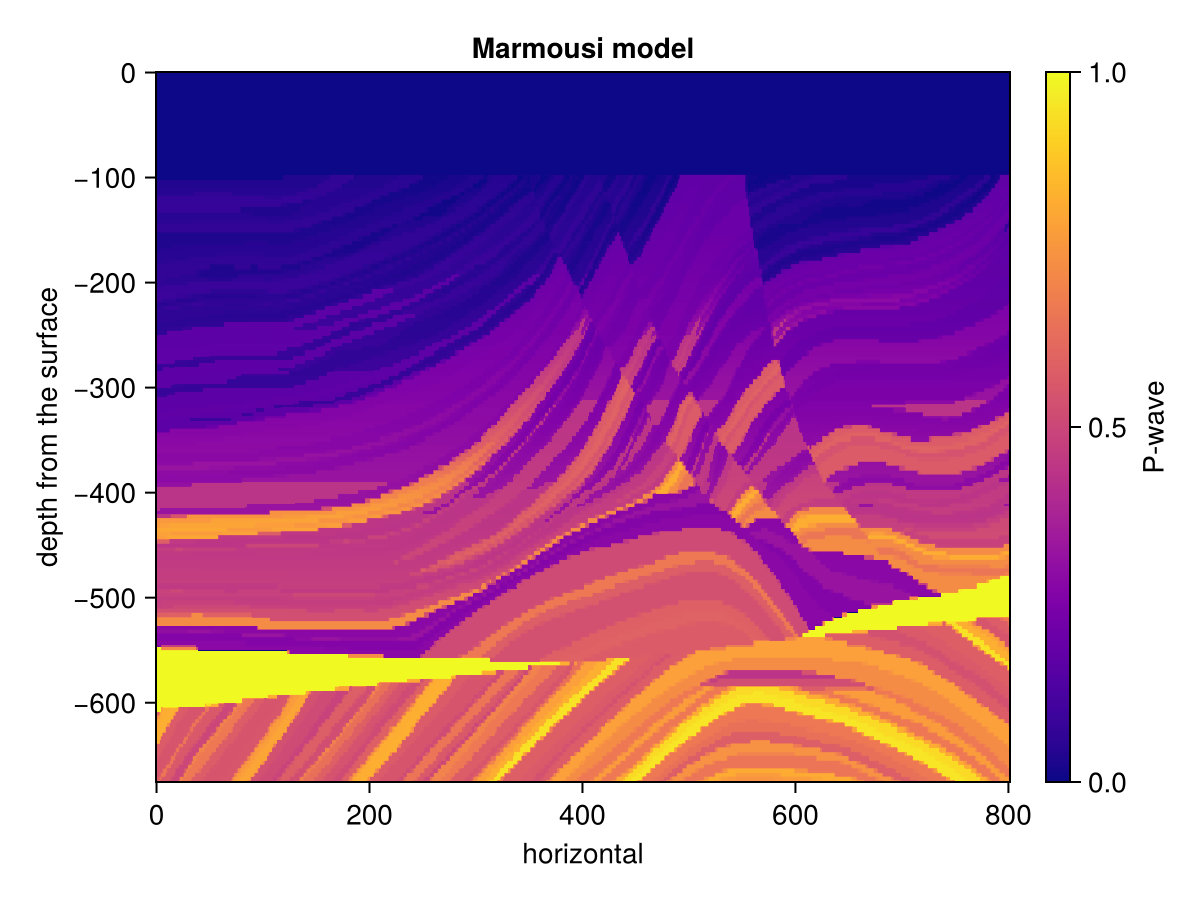

In [34]:
fig, ax, hm = heatmap(
    #topo.x,topo.y,topo.z';
    collect((0:1:(Nx-1)).*Δx),(collect(-(Nz-1)).*Δz:1:0), reverse(model',dims=2);
    colormap = :plasma,
    colorrange=(extrema(model)),
    axis = (xlabel = "horizontal", ylabel = "depth from the surface", title = "Marmousi model")
)
#ylims!(ax,-200,300)
#xlims!(ax,0,400)
Colorbar(fig[1,2], hm, label="P-wave")
fig

In [35]:
coordinates

(x, y, t)

In [36]:
Δnum = (1.0,1.0,1.0) # this should be in the same order as coordinates 



IneedExternalSources = true
maskedRegionForSourcesInSpace = nothing

#DrWatson configurations

orderBtime=1
orderBspace=1
pointsInSpace=2
pointsInTime=2

WorderBspace=1
WorderBtime=1
supplementaryOrder=2

2

In [37]:
models=[] # you might need to make this empty tuple first, otherwise one-member tuple can be misinterpreted
models=push!(models, (model .* 0.2 .+ 0.4))

1-element Vector{Any}:
 [0.4 0.4 … 0.4 0.4; 0.4 0.4 … 0.4 0.4; … ; 0.5138386099547898 0.5163891573813251 … 0.5501948972360029 0.5472638856339349; 0.5300777283024765 0.5308589172720881 … 0.5545259469249547 0.5545259469249547]

In [38]:
maximum(models[1])

0.6000000000000001

In [39]:
fakeNt = 1
timeMarching = any(a -> a === timeDimensionString, string.(coordinates)) 
if timeMarching
    fakeNt = pointsInTime+1
    modelPoints = (size(model)...,fakeNt) # Nx, Ny etc thing. Nt is also mentioned and it should be the last element!
else
    modelPoints = (size(model))
end

(676, 802, 3)

In [40]:
maskedRegionForSourcesInSpace  = Array{CartesianIndex,1}(undef,0) # it is important to decalre the type of this
maskedRegionForSourcesInSpace = push!(maskedRegionForSourcesInSpace, CartesianIndex(modelPoints[1:end-1].÷2))# in Ndimension (or Ndimension  - 1 if timeMarching)
# in this example, I put a point source at the centre of the model space

forceModels =((1.0)) # if your model does not have anything special material parameters then it's how it's written

concreteModelParameters = @strdict famousEquationType Δnum orderBtime orderBspace WorderBtime WorderBspace supplementaryOrder pointsInSpace pointsInTime IneedExternalSources modelName models modelPoints forceModels maskedRegionForSourcesInSpace iExperiment

Dict{String, Any} with 16 entries:
  "IneedExternalSources"          => true
  "models"                        => Any[[0.4 0.4 … 0.4 0.4; 0.4 0.4 … 0.4 0.4;…
  "maskedRegionForSourcesInSpace" => CartesianIndex[CartesianIndex(338, 401)]
  "iExperiment"                   => 1
  "orderBtime"                    => 1
  "Δnum"                          => (1.0, 1.0, 1.0)
  "pointsInSpace"                 => 2
  "WorderBspace"                  => 1
  "pointsInTime"                  => 2
  "WorderBtime"                   => 1
  "supplementaryOrder"            => 2
  "orderBspace"                   => 1
  "modelPoints"                   => (676, 802, 3)
  "forceModels"                   => 1.0
  "modelName"                     => "marmousi"
  "famousEquationType"            => "2DacousticTime"

In [41]:
#safeget(A, inds...; default=0) = checkbounds(Bool, A, inds...) ? A[inds...] : default

In [42]:
# we need to see what's happening inside makeCompleteCostFunctions

In [43]:
    @unpack famousEquationType, Δnum, orderBtime, orderBspace, WorderBtime,WorderBspace,supplementaryOrder,pointsInSpace, pointsInTime, IneedExternalSources, modelName, models, modelPoints, forceModels,maskedRegionForSourcesInSpace, iExperiment = concreteModelParameters
    exprs,fields,vars,extexprs,extfields,extvars,coordinates,∂,∂² = famousEquations(famousEquationType)
    global ∂,∂²
    
    # here we construct semi symbolic operators (with numerical Δnum)
    operatorConfigurations = @strdict famousEquationType Δnum orderBtime orderBspace WorderBtime WorderBspace supplementaryOrder pointsInSpace pointsInTime IneedExternalSources iExperiment


Dict{String, Any} with 11 entries:
  "IneedExternalSources" => true
  "iExperiment"          => 1
  "orderBtime"           => 1
  "Δnum"                 => (1.0, 1.0, 1.0)
  "pointsInSpace"        => 2
  "WorderBspace"         => 1
  "pointsInTime"         => 2
  "WorderBtime"          => 1
  "supplementaryOrder"   => 2
  "orderBspace"          => 1
  "famousEquationType"   => "2DacousticTime"

In [44]:
#instead of doing below
#operators = myProduceOrLoad(OPTobj,operatorConfigurations,"semiSymbolics")

In [45]:
 @unpack famousEquationType, Δnum, orderBtime, orderBspace, WorderBtime,WorderBspace,supplementaryOrder,pointsInSpace, pointsInTime,IneedExternalSources, iExperiment= operatorConfigurations

exprs,fields,vars,extexprs,extfields,extvars,coordinates,∂,∂² = famousEquations(famousEquationType)

TaylorOptions=(WorderBtime=WorderBtime,WorderBspace=WorderBspace,supplementaryOrder=supplementaryOrder)
trialFunctionsCharacteristics=(orderBtime=orderBtime,orderBspace=orderBspace,pointsInSpace=pointsInSpace,pointsInTime=pointsInTime)

(orderBtime = 1, orderBspace = 1, pointsInSpace = 2, pointsInTime = 2)

In [46]:
# instead of doing below
#@time operatorData=OPTobj(exprs,fields,vars; coordinates=coordinates,trialFunctionsCharacteristics=trialFunctionsCharacteristics,TaylorOptions=TaylorOptions,Δnum = Δnum,iExperiment=iExperiment)

In [47]:
# here is the internal contents of OPTobj

In [49]:


    @show timeMarching = any(a -> a === timeDimensionString, string.(coordinates))


    @unpack orderBtime, orderBspace, pointsInSpace, pointsInTime = trialFunctionsCharacteristics
    @unpack WorderBtime, WorderBspace,supplementaryOrder = TaylorOptions

    NtypeofExpr=length(exprs)   # number of governing equations
    NtypeofMaterialVariables=length(vars) # number of material coefficients
    NtypeofFields=length(fields) # number of unknown fields
    
    Ndimension = length(coordinates) # we do not change this for the moment, especially for the time-marching scheme
    pointsUsed = ones(Int, Ndimension).*(pointsInSpace+1)
    if timeMarching
        pointsUsed[end]=pointsInTime+1
    end


    if length(Δnum) !== Ndimension && !CˡηSymbolicInversion
        @error "the numerical delta increment has not the same dimension!"
    end

timeMarching = any((a->begin
                #= /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/myOwnApplications/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X30sZmlsZQ==.jl:3 =#
                a === timeDimensionString
            end), string.(coordinates)) = true


In [50]:
 #region investigation of all the fields and vars dependencies in terms of x-y-z-t

    variableDependency=ones(Int,Ndimension)
    fieldDependency=ones(Int,Ndimension)
    eachVariableDependency=ones(Int,Ndimension,NtypeofMaterialVariables) 
    eachFieldDependency=ones(Int,Ndimension,NtypeofFields)
  
    for iFields in 1:NtypeofFields
        eachFieldDependency[:,iFields]=findCartesianDependency(fields[iFields],Ndimension)
        fieldDependency = fieldDependency .* (ones(Int,Ndimension).-eachFieldDependency[:,iFields])
    end


    for iVars in 1:NtypeofMaterialVariables
        eachVariableDependency[:,iVars]=findCartesianDependency(vars[iVars],Ndimension)
        variableDependency = variableDependency .* (ones(Int,Ndimension).-eachVariableDependency[:,iVars])
    end

    

    fieldDependency = ones(Int,Ndimension).-fieldDependency
    variableDependency = ones(Int,Ndimension).-variableDependency

    # here we correct variableDependency with fieldDependency: if fieldDependency is zero then we do not take care of that dimension for the variables
    variableDependency = variableDependency .* fieldDependency

    #endregion

3-element Vector{Int64}:
 1
 1
 0

In [51]:
#region definition of points in time and space to be used

    # heaviside(x) = x > 0 ? 1 : x == 0 ? 0 : -1

    # the orders of B-spline functions, depending on fields 

    orderBspline=zeros(Int,Ndimension)
    WorderBspline=zeros(Int,Ndimension)

    if timeMarching
        orderBspline[Ndimension]=orderBtime*fieldDependency[Ndimension]
        orderBspline[1:Ndimension-1]=orderBspace*fieldDependency[1:Ndimension-1]
        WorderBspline[Ndimension]=WorderBtime*fieldDependency[Ndimension]
        WorderBspline[1:Ndimension-1]=WorderBspace*fieldDependency[1:Ndimension-1]
    else
        orderBspline[1:Ndimension]=orderBspace*fieldDependency[1:Ndimension]
        WorderBspline[1:Ndimension]=WorderBspace*fieldDependency[1:Ndimension]
    end
    
    # the maximum number of points used in the vicinity of the node, which is independent of the order of B-spline functions (see our paper)
    pointsUsedForFields=(pointsUsed.-1).*fieldDependency.+1

    # orderExpressions is the maximal orders of partials that we could expect in the expressions
    orderExpressions=pointsUsedForFields
    
    # numbers of points to evaluate the integral for the governing equation filtered by the test functions
    
    # orderU is the maximum orders for the fields that we will use for OPT coefficients' exploration
    orderU = (orderExpressions .-1) .+ (supplementaryOrder .*fieldDependency).+1 
    # we restore this orderU since we need to control this 

    #endregion

3-element Vector{Int64}:
 5
 5
 5

In [52]:
#region analysis of expressions to obtain the α_{n'nji}

    bigα=Array{Any,2}(missing,NtypeofFields,NtypeofExpr)
    varM=nothing
    for iExpr in eachindex(exprs)
        for iField in eachindex(fields)
            
            tmpNonZeroAlphas=PDECoefFinder(orderExpressions,coordinates,exprs[iExpr],fields[iField],vars) 
            # we assume that the pointsUsedForFields represent the highest order of partials
            bigα[iField,iExpr]=unique(tmpNonZeroAlphas)
        end
    end
    varM=varMmaker(pointsUsedForFields,coordinates,vars)
    @show bigα,varM
    #endregion

    #region Preparation for Taylor expansion
    
    orderTaylors=Array{Any,Ndimension}(undef,Tuple(orderU))
    pointsInSpaceTime=Array{Any,Ndimension}(undef,Tuple(pointsUsedForFields))
    
    
    multiOrdersIndices=CartesianIndices(orderTaylors)

    availablePointsConfigurations = Array{Array{Vector{Int64},Ndimension},1}()
    centrePointConfigurations=Array{Int64,1}()

    #endregion

    #region Cartesian indices that can be available to use (normally: iGeometry=1)

    multiPointsIndices=CartesianIndices(pointsInSpaceTime)
    # this is the whole local Cartesian grids (without any lacking points)
    
    tmpVecForMiddlePoint = ((car2vec(multiPointsIndices[end]).-1 ).÷2 ).+1 # only valid for testOnlyCentre
    midTimeCoord = nothing
    if timeMarching
        midTimeCoord=car2vec(multiPointsIndices[end])[end]-1
        tmpVecForMiddlePoint[end]=midTimeCoord
        #AjiννᶜU = Array{Num,2}(undef,length(multiPointsIndices)÷(midTimeCoord+1),NtypeofExpr)
    end
    #@show tmpVecForMiddlePoint 
    middleν=vec2car(tmpVecForMiddlePoint)


    availablePointsConfigurations=push!(availablePointsConfigurations,car2vec.(multiPointsIndices))
    centrePointConfigurations=push!(centrePointConfigurations,LinearIndices(multiPointsIndices)[middleν])

    #endregion

(bigα, varM) = (Any[Any[(node = -(v(x, y)^2), nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(3, 1, 1)), (node = -(v(x, y)^2), nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(1, 3, 1)), (node = 1, nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(1, 1, 3))];;], Any[v₁ v₂ v₃ v₄ v₅ v₆ v₇ v₈ v₉ v₁ v₂ v₃ v₄ v₅ v₆ v₇ v₈ v₉ v₁ v₂ v₃ v₄ v₅ v₆ v₇ v₈ v₉])


1-element Vector{Int64}:
 14

In [53]:
CˡηSymbolicInversion=false

false

In [54]:
 #region obtaining the semi-symbolic expression of cost function based on eqns. 52 and 53.

    # before calling AuSymbolic we can manipulate pointsIndices for various boundary configurations


    if CˡηSymbolicInversion # this seems super cool but it takes time
        #Cˡη,Δ,multiLCar = illposedTaylorCoefficientsInversion(coordinates,multiOrdersIndices,multiPointsIndices;testOnlyCentre=testOnlyCentre,timeMarching=timeMarching)
        Δ = Symbolics.variables(:Δ,1:Ndimension)
    else
        Δ = Δnum
    end

    AjiννᶜU=[]
    Ulocal=[]

    for iConfigGeometry in eachindex(availablePointsConfigurations) 
        @show pointsIndices=availablePointsConfigurations[iConfigGeometry]
        @show middleLinearν=centrePointConfigurations[iConfigGeometry]
        tmpAjiννᶜU,tmpUlocal=ASymbolic(coordinates,multiOrdersIndices,pointsIndices,multiPointsIndices,middleLinearν,Δ,varM,bigα,orderBspline,WorderBspline,NtypeofExpr,NtypeofFields)



        #varM is given above for the max number of points used 
        #tmpAjiννᶜU,tmpUlocal=AuSymbolic(coordinates,multiOrdersIndices,pointsIndices,multiPointsIndices,middleLinearν,Δ,varM,bigα,orderBspline,WorderBspline,NtypeofExpr,NtypeofFields)
        AjiννᶜU=push!(AjiννᶜU,tmpAjiννᶜU)
        Ulocal=push!(Ulocal,tmpUlocal)
    end


    #endregion


pointsIndices = availablePointsConfigurations[iConfigGeometry] = [[1, 1, 1] [1, 2, 1] [1, 3, 1]; [2, 1, 1] [2, 2, 1] [2, 3, 1]; [3, 1, 1] [3, 2, 1] [3, 3, 1];;; [1, 1, 2] [1, 2, 2] [1, 3, 2]; [2, 1, 2] [2, 2, 2] [2, 3, 2]; [3, 1, 2] [3, 2, 2] [3, 3, 2];;; [1, 1, 3] [1, 2, 3] [1, 3, 3]; [2, 1, 3] [2, 2, 3] [2, 3, 3]; [3, 1, 3] [3, 2, 3] [3, 3, 3]]
middleLinearν = centrePointConfigurations[iConfigGeometry] = 14
integral1DWYYKK[iCoord] = output["intKernelforνLΔ"] = Any[0.08333333333333332870740406406184774823486804962158203125 0.08333333333333332870740406406184774823486804962158203125 0//1; 0.08333333333333332870740406406184774823486804962158203125 0.5000000000000002035408878479453657443324724833170572916666666666666666666667127 0.08333333333333333333333333333333333333333333333333333333333333333333333333333369; 0//1 0.08333333333333333333333333333333333333333333333333333333333333333333333333333369 0.08333333333333332870740406406184774823486804962158203125;;; -0.050000000000001598721155460

In [ ]:
typeof(AjiννᶜU)

In [ ]:
@profilehtml opt = myProduceOrLoad(makeCompleteCostFunctions,concreteModelParameters,"numOperators","quasiNum")


In [ ]:
statprofilehtml()

In [ ]:
using InteractiveUtils
run(`open /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/myOwnApplications/statprof/index.html`)  

In [ ]:
function buggy_function()
    s = 0
    for i in 1:10^7
        s += sin(i)
        if i == 5_000_000
            error("boom!")
        end
    end
    return s
end

try
    @profilehtml buggy_function()
catch err
    @warn "Crashed" err
end

# Show the flamegraph in your browser
statprofilehtml()

In [ ]:
using InteractiveUtils
run(`open /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/myOwnApplications/statprof/index.html`)  